# Product Analysis

In [1]:
#Import the libraries
import numpy as np
import pandas as pd
import pyodbc
import warnings
import seaborn as sns
from sklearn.cluster import AffinityPropagation
import distance
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher

# Ignore Warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Retrieve Database-Server Lookup Table

In order to retrieve products from each vendor, it is necessary we connect to multiple different servers and databases. To do this, we must first retrieve a table to reference which databases are on which servers. This is found on the ``Org`` data base on the ``config`` server. All connections will use the read-only connections details.

In [2]:
# Server authorization details
UID = 'kappture_ro'
PWD = 'xt42qPK188dsWn'

# Server and Database connection details
server_lookup = 'oltp-config-1.c9720j1ytny1.eu-west-1.rds.amazonaws.com'
db_lookup = 'Org'

# SQL Query
sql_lookup ='''
            SELECT OrgId,
            Description,
            Operator,
            serverOLTP,
            DatabaseOLTP
            from Org.dbo.Production
            where IsDisabled is null  
            and not Operator = 'Kappture Sales'
            order by Description asc
            '''

Execute SQL query. Collapse the returned table down to a dictionary of lists, where the servers are the keys and the databases within them are lists. 

In [3]:
# Connection details
connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+server_lookup+';DATABASE='+db_lookup+';UID='+UID+';PWD='+ PWD

# DB Connection details
cnxn = pyodbc.connect(connection_string) 

# SQL Query returned as DataFrame
servers = pd.read_sql(sql_lookup, cnxn) 

# Reshape as a dict of lists
db_ref = servers.groupby('serverOLTP')['DatabaseOLTP'].apply(list).to_dict() 

# For convenience we will save out the list of servers
serv_list = list(db_ref.keys()) 

## Iterate over Companies on Server

### Pull All Products from All Venues

User the Database-Server lookup dictionary, we can iterate over all the vendors to pull in a complete list of products

In [4]:
# SQL Query to retrieve unique products over a one-month period
sql_prod =   '''select ProductName, ProductGroupName from (select o.*,
                FORMAT(o.Datetime, 'dd/MM/yyyy ') as Date,
                P.Name as ProductName,
                PG.Name as ProductGroupName, 
                Ot.TransactionId,
                T.OutletID,T.TerminalVendorID,T.Name as TerminalName,
                OTL.Line, OTL.ProductID,OTL.ProductGroupID,OTL.Quantity,OTL.Value,
                Ou.SiteID,Ou.name as OutletName,
                S.Name as SiteName,
                C.Name as CompanyName
                FROM [r].[Order] O
                left join 
                [r].[OrderTransaction] OT on o.OrderID = OT.OrderID
                left join 
                [r].[OrderTransactionLine] OTL on o.OrderID = OTL.OrderID
                left join 
                [rsync].[Terminal] T on T.terminalID = o.TerminalID
                left join 
                [rsync].[Outlet] Ou on Ou.OutletID = T.OutletID
                left join 
                [ssync].[Product] P on P.ProductID = OTL.ProductID
                left join 
                [ssync].[ProductGroup] PG on PG.ProductGroupID = P.ProductGroupID 	
                left join 
                [rsync].[Site] S on S.SiteID = Ou.SiteID 	
                left join 
                [rsync].[Company] C on C.CompanyID = S.SiteID
                where 1=1 
                and not Quantity is null
                and not P.ProductgroupID = 52
                and DateTime between '10/07/2021' and '11/09/2021') as a
                group by ProductName, ProductGroupName
                '''

In [6]:
# Initialize DataFrame
connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+serv_list[0]+';DATABASE='+db_ref[serv_list[0]][0]+';UID='+UID+';PWD='+ PWD

# SQL Query returning products
cnxn = pyodbc.connect(connection_string)
df = pd.read_sql(sql_prod, cnxn)

# Create DataFrame from first database on first server
df['DB'], df['Server'] = db_ref[serv_list[0]][0], serv_list[0]

# Append Row Count for Remaining DBs
# Loop over each server
for s in db_ref: 
    # Loop over each database on each server (skipping first record, already added)
    for db in db_ref[s][1:]: 
        connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+s+';DATABASE='+db+';UID='+UID+';PWD='+ PWD
        cnxn = pyodbc.connect(connection_string)
        df_prod = pd.read_sql(sql_prod, cnxn)
        df_prod['DB'], df_prod['Server'] = db, s
        df = pd.concat([df, df_prod])
df.reset_index(drop=True, inplace=True)
display(df)

# Save to CSV
if not os.path.exists('exports'):
    os.makedirs('exports')
df.to_csv('exports/Products.csv')

,ProductName,ProductGroupName,DB,Server
0,COSTA M AMERICANO,COSTA,MN00000001,oltp-prod-1.c9720j1ytny1.eu-west-1.rds.amazona...
1,Jelly Pot,BREAKFAST,MN00000001,oltp-prod-1.c9720j1ytny1.eu-west-1.rds.amazona...
2,HARIBO TANGFAST,CONFECTIONARY,MN00000001,oltp-prod-1.c9720j1ytny1.eu-west-1.rds.amazona...
3,Real Wrap C,BREAKFAST,MN00000001,oltp-prod-1.c9720j1ytny1.eu-west-1.rds.amazona...
4,BUTTERED COB,BREAKFAST,MN00000001,oltp-prod-1.c9720j1ytny1.eu-west-1.rds.amazona...
...,...,...,...,...
31228,ZZZZZ & Fan Cup Wolfpack Half,Wolfpack Half Pint & Fan Cup (*S),MZ00000001,oltp-prod-9.c9720j1ytny1.eu-west-1.rds.amazona...
31229,House Wine Rose 125ml,Wines (*S),MZ00000001,oltp-prod-9.c9720j1ytny1.eu-west-1.rds.amazona...
31230,Cereal Bar,Snacks (*S),MZ00000001,oltp-prod-9.c9720j1ytny1.eu-west-1.rds.amazona...
31231,ZZZZRude or Aggressive,Refusal of service,MZ00000001,oltp-prod-9.c9720j1ytny1.eu-west-1.rds.amazona...


In [66]:
df['ProductName'].value_counts()

Flat White                                 36
Hash Brown                                 35
Espresso                                   33
Toast                                      33
Hot Chocolate                              33
                                           ..
Flavoured chicken of the week Tandoori      1
Coffee & Cake Deal                          1
Tuna Mayonnaise & Cucumber Baguette         1
Real Crisps Roast Ox                        1
ZZZZRude or Aggressive                      1
Name: ProductName, Length: 25369, dtype: int64

#### Create List of Unique Product Names

In [58]:
# Group by Product Name
products = df[['ProductName', 'Server']].groupby(['ProductName']).count().sort_values('Server', ascending=False)
products.columns = ['Count']
if not os.path.exists('exports'):
    os.makedirs('exports')
products.to_csv('exports/UniqueProducts.csv')

# Group records by Product and Product Group
products_grp = df[['ProductName', 'ProductGroupName', 'Server']].groupby(['ProductName', 'ProductGroupName']).count().sort_values('Server', ascending=False)
products_grp.columns = ['Count']
if not os.path.exists('exports'):
    os.makedirs('exports')
products_grp.to_csv('exports/UniqueProducts_w_Group.csv')

In [64]:
products

,Count,Unique
ProductName,,
Flat White,36,False
Hash Brown,35,False
Toast,33,False
Hot Chocolate,33,False
Espresso,33,False
...,...,...
Feast For Two,1,True
Feast Box,1,True
Feast,1,True


### Exploration

An exploration into how many vendors share product names.

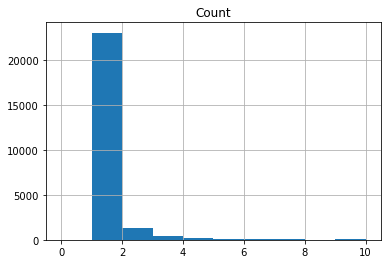

In [59]:
products.hist(figsize=(6,4), range=[0,10]);

It appears the vast majority of Product Names appear only once on our database.

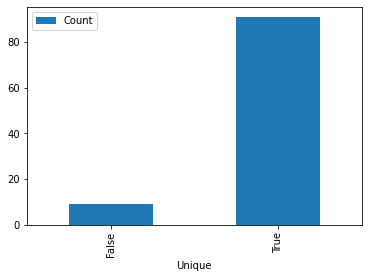

In [67]:
# Create column identifying if the Product Name is unique
products['Unique'] = products['Count'] == 1

# Percentage of Unique Product Names
(products.groupby('Unique').count()/len(products)*100).plot.bar();

In [61]:
products

,Count,Unique
ProductName,,
Flat White,36,False
Hash Brown,35,False
Toast,33,False
Hot Chocolate,33,False
Espresso,33,False
...,...,...
Feast For Two,1,True
Feast Box,1,True
Feast,1,True


<AxesSubplot:ylabel='ProductName'>

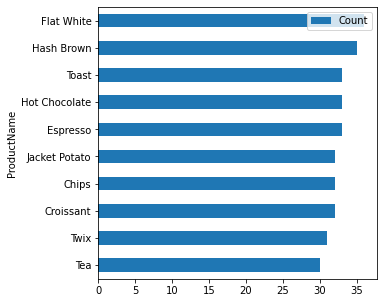

In [71]:
# Display some items common across many vendors
products.head(10)[::-1].plot.barh(figsize=(5,5))

### Various Fuzzy Matching Techniques

In [32]:
def fuzzy_match(data, column='ProductName', method='levenshtein', sample=1000):
    
    """This function will operate on a DataFrame column to return high-level groupings. It groups similar items together using a specified distance metric.

    Args:
        data (DataFrame): DataFrame that contains the column to operate on.
        column (str, optional): The column over which to group similar records. Defaults to 'ProductName'.
        method (str, optional): The distance metric to use to determine similar records. Defaults to 'levenshtein'.
        sample (int, optional): Downsamples the DataFrame to the provided number of records. Defaults to 100.

    """

    words = list(data[column].sample(sample)) # List of Products
    words = np.asarray(words) # So that indexing with a list will work

    # Various distance metrics
    if method=='levenshtein': # Okay
        similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])
    if method=='sorensen': # Okay
        similarity = -1*np.array([[distance.sorensen(w1,w2) for w1 in words] for w2 in words])
    if method=='jaccard': # Not Good
        similarity = -1*np.array([[distance.jaccard(w1,w2) for w1 in words] for w2 in words])
    if method=='fuzzy': # Bad
        similarity = -1*np.array([[fuzz.ratio(w1,w2) for w1 in words] for w2 in words])
    if method=='difflib': # Bad
        similarity = -1*np.array([[SequenceMatcher(None, w1,w2).ratio() for w1 in words] for w2 in words])

    affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
    affprop.fit(similarity)
    exemplar_list, cluster_list = [], []
    for cluster_id in np.unique(affprop.labels_):
        exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
        cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
        cluster_str = ", ".join(cluster)
        exemplar_list.append(exemplar)
        cluster_list.append(cluster_str)
    
    # Check directories exists
    if not os.path.exists('exports'):
        os.makedirs('exports')
    if not os.path.exists('exports/clusters'):
        os.makedirs('exports/clusters')
    
    # Export and print
    df = pd.DataFrame([exemplar_list, cluster_list]).T
    df.columns = ['Exemplar', 'Cluster']
    df.to_csv('exports/clusters/'+method+'_clusters.csv')
    display(df)

#### Levenshtein

In [33]:
fuzzy_match(df, method='levenshtein') # 1m21s runtime

,Exemplar,Cluster
0,Poriddge with Shredded Carrot,Poriddge with Shredded Carrot
1,Champagne Bottle,"Birra Moretti Bottle, Champagne Bottle, Coca C..."
2,Breakfast Bap,"Breakfast Bap, Breakfast Box 1, Breakfast Extr..."
3,Sausage Roll,"4 x Fudge Cone, Baguette 2.60, Franco's Cola I..."
4,Disaronno Single,"Brighton Gin Single, De Martino Estate, Disaro..."
...,...,...
187,Sugar ring doughnut,"Dairy Milk Wholenut, Glazed Doughnut, Hot Drin..."
188,Cheese Burger & Chips,"Cheese Burger & Chips, Cheese and Onion Crisps..."
189,"C?tes du Rh?ne, Cuv?e St Laurent","C?tes du Rh?ne, Cuv?e St Laurent"
190,Chicken Skewer With Coriander Rice HO,Chicken Skewer With Coriander Rice HO


#### Sorensen

In [34]:
fuzzy_match(df, method='sorensen') # 2.9s runtime

,Exemplar,Cluster
0,7up,7up
1,Choc Pastry,"54 north cans, Berry Bircher Pot , Choc Bar, C..."
2,Hash Brown,"Hash Brown, Hash Brown"
3,Malibu 25ml,"Absolut Vodka 25ml, Malibu 25ml, Red bull 355m..."
4,Open Food,"Open Food, Open Item"
...,...,...
109,Extra Shot,"Extra Espresso Shot, Extra Hot, Extra Shot, GH..."
110,Syrup Shot,"Shipyard IPA, Syrup Shot, Syrup Shot"
111,Toast,"Eggs & Toast SS, Taro, Toast"
112,ComHoney1.16L,"ComHoney1.16L, Honey"


#### Jacard

In [36]:
fuzzy_match(df, method='jaccard') # 3.5s runtime

,Exemplar,Cluster
0,Choc Bar,"B16 Macon Charn, Choc Bar, Doom Bar, Freshers ..."
1,Tomato & Cheese Panini,"Bacon & Cheese Panini , Che & Oni Pasty (t), C..."
2,Battered Sausage,"Baguette/Wrap, Barebells Salty Peanut SS, Batt..."
3,Tanqueray Double,"""EveryDay"" Colour A2, Herbal Tea , Kraken Doub..."
4,Extra Jacket Fillings,"Eat Natural bar cranberries 50g, Extra Jacket ..."
...,...,...
122,Toasties,"Deposit, Head Ties, Niccoise, Thats Life, Toas..."
123,Smirnoff Vodka 25ml,"Cognac VS 25ml, Okra Salona, Smirnoff Vodka, S..."
124,1/4lb beef burger,"1/4 Beef Burger, 1/4lb beef burger, Double Bee..."
125,Sunday sandwich,"Owners Sunday Lunch Walk-In, Sandwiches & Bagu..."


#### Fuzzy

In [37]:
fuzzy_match(df, method='fuzzy') # 22.7s runtime

,Exemplar,Cluster
0,Gum,"1p, Refectory Tea, *Classic Sandwich Range, ..."
1,7UP,"*1x Scoop Vanilla, 1 x Cookie , 1/2 Caledonia ..."
2,BLT,"""Premium"" Colour A2, % Kopparberg Cider, *Mar..."
3,MOCHA,"*Fruit Salad/Grapes Pot, 18.Imperativo Prosecc..."
4,Burger,"1/4 ROSE PROSECCO , 12oz XMAS CERAMIC MUG, 16o..."
5,YORKIE,"Wagyu Beef سلطة الس, * Coconut Milk, 125ml - ..."
6,Twix,"100g Bag, 4 Item Breakfast, APPLE (RED/GREEN),..."


#### DiffLib

In [38]:
fuzzy_match(df, method='difflib') # 21.7s runtime

,Exemplar,Cluster
0,QUINOA,"*Bubble innocent, 125ml - Montepulciano, 16.Ga..."
1,WKD,"*Add on 1.30, 1 Fruit piece 1.10, 125ML MANCUR..."
2,Food,"125ML SANTA ALEGRA CHARDONNAY, 175ml - Rieslin..."
3,£3.50,"Sanded Buff Stoneware, 'A' sauvingnon blanc R..."


## Deduplication

There is a deduplication library that might be worth investigating

In [2]:
# Deduple Library
import pandas_dedupe

# Read in Unique Products List
products = pd.read_csv('exports/UniqueProducts.csv')

# Use Library to deduplicate similar records
prod_ded = pandas_dedupe.dedupe_dataframe(products, ['ProductName'])